## Part1:人民币识别代码

### 1、人民币数据的整理

### 2、人民币识别模型代码

### 3、人民币模型加载和使用

---

### 1、人民币数据的整理

In [ ]:
import os,shutil

face_value_label = open('./RMB_data_set/train_face_value_label.csv','r')

start_dir = './RMB_data_set/train_data/' #数据原始目录
target_dir = './RMB_data_set/mkdir_train_data/'      #数据最终目录

dictionary = {'0.1':'A','0.2':'B','0.5':'C','1':'D','2':'E','5':'F','10':'G','50':'H','100':'I'}
#采用合理的名字给文件进行命名

lable_lists = face_value_label.readlines()
si = 0
if os.path.isdir(target_dir) == False:
    os.mkdir(target_dir)
    #如果没有目标目录，就创建一个目录

max_num = len(os.listdir(start_dir))
#获得初始文件夹中图片的数量

for li in lable_lists:
    li = li[:-1]
    name_label = li.split(',')
    if name_label[0] == 'name':
        continue #第一行数据是无效数据，不进行处理
    if os.path.isfile('{0}/{1}'.format(start_dir,name_label[0])) == True:
        
        if os.path.isdir('{0}label_{1}'.format(target_dir,dictionary[name_label[1].strip()])) == False:
#             print('{0}{1}'.format(start_dir,name_label[0]))
            os.mkdir('{0}label_{1}'.format(target_dir,dictionary[name_label[1].strip()]))
        shutil.copy('{0}{1}'.format(start_dir,name_label[0]),'{0}label_{1}/{2}'.format(target_dir,dictionary[name_label[1].strip()],name_label[0]))
        #创建文件夹并移动文件
        si += 1 #记录次数
        progress = (si / max_num) * 100
        progress = round(progress,1)
        #progress = si / len(os.listdir('./val_data_test/'))
        if progress % 10 == 0:
            print('成功复制{0},进度：{1}%'.format(name_label[0],progress))
            #打印复制进度


----
### 2、人民币识别模型代码

Found 604 images belonging to 9 classes.
Found 596 images belonging to 9 classes.
Epoch 1/30
61/30 [=============================================================] - 15s 252ms/step - loss: 2.1809 - acc: 0.1446 - val_loss: 2.1354 - val_acc: 0.2483
Epoch 2/30
61/30 [=============================================================] - 14s 236ms/step - loss: 1.9870 - acc: 0.2561 - val_loss: 1.7908 - val_acc: 0.2416
Epoch 3/30
61/30 [=============================================================] - 16s 259ms/step - loss: 1.6602 - acc: 0.3605 - val_loss: 1.5493 - val_acc: 0.4111
Epoch 4/30
61/30 [=============================================================] - 14s 228ms/step - loss: 1.3130 - acc: 0.5192 - val_loss: 1.0066 - val_acc: 0.6711
Epoch 5/30
61/30 [=============================================================] - 14s 232ms/step - loss: 1.2068 - acc: 0.5387 - val_loss: 1.0394 - val_acc: 0.6007
Epoch 6/30
61/30 [=============================================================] - 15s 254ms/step 

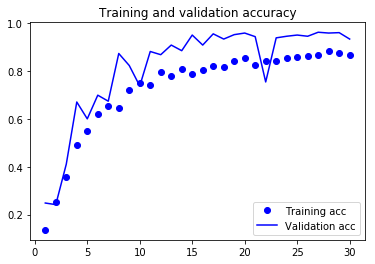

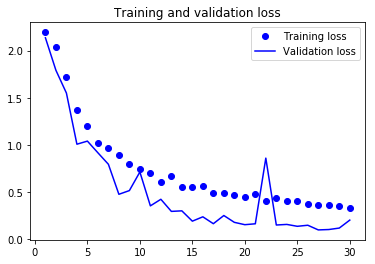

In [4]:
from keras import layers
from keras import models
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
#设置文件目录

#训练集
trainDir = './RMB_train_dataset/train/'      #数据最终目录
# trainDir ='H:/face_value_check/train_data/'

#验证集
# valDir = 'H:/face_value_check/val_data/'
valDir = './RMB_train_dataset/validation/'      #数据最终目录

#创建模型
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(240, 120, 3)))
#卷积层，输出空间的维数为32,也可以说是输出特征图的深度为32，提取信息的窗口大小(3,3),卷积核的大小也为(3,3)
#激活函数relu,输入图片大小(150,150,3)
model.add(layers.MaxPooling2D((2, 2)))
#池化层，窗口大小为(2,2)，缩小特征图的尺寸
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
#扁平层,将多维的输入转化为一维的输出
model.add(layers.Dropout(rate=0.5))
#这个层是可以删掉的，主要用来防止过拟合，放着也没事
model.add(layers.Dense(512, activation='relu'))
#全连接层，将提取的特征组合，得出结果
model.add(layers.Dense(9, activation='softmax'))
#因为要得出九个结果所以最后要输出九个数

#设置损失函数，优化器，模型在训练和测试时的性能指标
from keras import optimizers

model.compile(loss='categorical_crossentropy',#因为是多标签分类，所以使用categorical_crossentropy
  optimizer=optimizers.RMSprop(lr=1e-4),#这里可以设置学习率
  metrics=['acc'])

#配置图片生成器
from keras.preprocessing.image import ImageDataGenerator
#将图片像素缩小为[0,1]之间的浮点数

#本次人民币面值特征比较明显，而且会摆的整整齐齐的让你识别，数据也比较多，所以不用数据增强
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,#图像随机旋转的最大角度
    width_shift_range=0.2,#图片在水平位置上偏移的最大百分比值
    height_shift_range=0.2,#数值位置上
    shear_range=0.2,#随机错位切换的角度
    zoom_range=0.2,#图片随机缩放的范围
    horizontal_flip=True)#随机将一半的图片进行水平翻转

#验证集的数据不能增强
val_datagen = ImageDataGenerator(rescale=1./255)

#创建图片生成器
train_generator = train_datagen.flow_from_directory(
     trainDir,#图片地址
     target_size=(240, 120),#将图片调整为(150,150)大小
     batch_size=10,#设置批量数据的大小为20
     class_mode='categorical')#设置返回标签的类型

val_generator = val_datagen.flow_from_directory(
     valDir,
     target_size=(240, 120),
     batch_size=10,
     class_mode='categorical')

# print(valDir,trainDir)
# while True:
#     a=0
#拟合模型
history = model.fit_generator(
  train_generator,
  steps_per_epoch=30,#迭代进入下一轮次需要抽取的批次
  epochs=30,#数据迭代的轮数
  validation_data=val_generator,
  validation_steps=30)#验证集用于评估的批次

#保存模型
model.save('RMBRecongnition.h5')
model.summary()

#画出结果
import matplotlib.pyplot as plt

#history.history中就只有这四个值，分别是准确度，验证集准确度，损失，验证集损失
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#画两个图，分别是正确率和损失
#正确率
plt.figure(1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('acc1.png')
plt.show()
#验证损失
plt.figure(2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss1.png')
plt.show()

---

### 3、人民币模型加载和使用

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

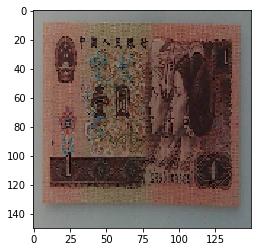

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.]]
预测结果输出：


In [4]:
# %matplotlib inline#在jupyter 内部显示图片
import matplotlib
# matplotlib.use('Agg')
import os
from keras.models import load_model
import numpy as np
from PIL import Image
import cv2

import matplotlib.pyplot as plt

min_side = 150

def process_image(img):
    size = img.shape
    h, w = size[0], size[1]
    #长边缩放为min_side 
    scale = max(w, h) / float(min_side)
    new_w, new_h = int(w/scale), int(h/scale)
    resize_img = cv2.resize(img, (new_w, new_h))
    # 填充至min_side * min_side
    if new_w % 2 != 0 and new_h % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2, (min_side-new_h)/2, (min_side-new_w)/2 + 1, (min_side-new_w)/2
    elif new_h % 2 != 0 and new_w % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2 + 1, (min_side-new_h)/2, (min_side-new_w)/2, (min_side-new_w)/2
    elif new_h % 2 == 0 and new_w % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2, (min_side-new_h)/2, (min_side-new_w)/2, (min_side-new_w)/2
    else:
        top, bottom, left, right = (min_side-new_h)/2 + 1, (min_side-new_h)/2, (min_side-new_w)/2 + 1, (min_side-new_w)/2
    pad_img = cv2.copyMakeBorder(resize_img, int(top), int(bottom), int(left), int(right), cv2.BORDER_CONSTANT, value=[0,0,0]) #从图像边界向上,下,左,右扩的像素数目
    #print pad_img.shape
    #cv2.imwrite("after-" + os.path.basename(filename), pad_img)
    return pad_img

#加载模型h5文件
model = load_model("RMBRecongnition.h5")
model.summary()
#规范化图片大小和像素值
images_1 = r'./public_test_data/0A2MIKHN.jpg'

input = cv2.imread(images_1)
# input = process_image(input)
input = cv2.resize(input, (150, 150))
input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)

plt.figure("dog")
plt.imshow(input)
plt.show()

pre_x = np.expand_dims(input, axis=0)
#调用函数，规范化图片
# pre_x = get_inputs(images)
#预测
pre_y = model.predict(pre_x)
print(pre_y)
print("预测结果输出：")
#  classes=['1Jiao', '2Jiao', '5Jiao', '2Jiao', '1Yuan', '2Yuan', '5Yuan', '10Yuan', '50Yuan', '100Yuan'],
# if pre_y[0] >0.5:
#     print("识别结果：狗狗")
# else:
#     print("识别结果：猫猫")